# Image Classification with MobileNetV2

## Import Required Libraries

In [3]:
# Importing necessary libraries
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import cv2
from PIL import Image
import seaborn as sns

## Define Paths and Hyperparameters

In [5]:
# Define the paths to the dataset and hyperparameters
train_path = './dataset_2'
test_path = './test'

IMG_SIZE = (256, 256)
BATCH_SIZE = 32
EPOCHS = 15

## Dataset Structure

In [7]:
# Function to count the number of images in each class
def count_images_by_class(path):
    return {cls: len(os.listdir(os.path.join(path, cls))) for cls in os.listdir(path)}


# Count number of images per class
train_counts = count_images_by_class(train_path)
test_counts = count_images_by_class(test_path)

# Output train and test class distributions
print("Train class distribution:", train_counts)
print("Test class distribution:", test_counts)

# Total images in the training and testing datasets
print("Total training images:", sum(train_counts.values()))
print("Total test images:", sum(test_counts.values()))

Train class distribution: {'glioma': 120, 'meningioma': 120, 'notumor': 120, 'pituitary': 120}
Test class distribution: {'glioma': 120, 'meningioma': 120, 'notumor': 120, 'pituitary': 120}
Total training images: 480
Total test images: 480


## Visualizing the Data

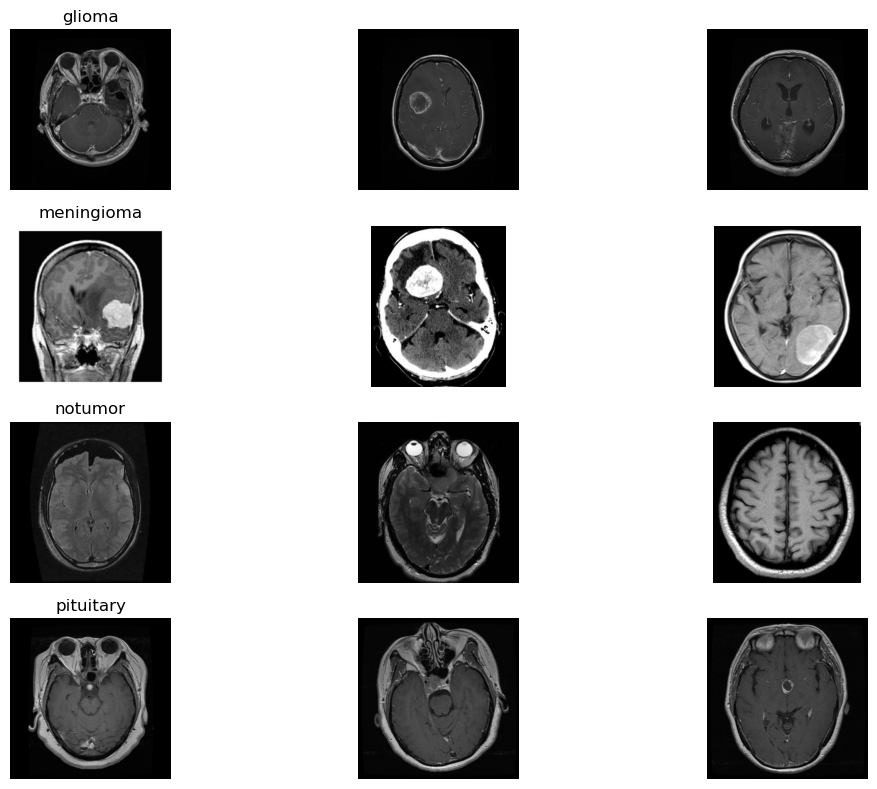

In [9]:
# Function to plot sample images from each class
def plot_sample_images(path, n=3):
    fig, axes = plt.subplots(len(os.listdir(path)), n, figsize=(12, 8))
    for i, cls in enumerate(os.listdir(path)):
        cls_path = os.path.join(path, cls)
        for j, img_name in enumerate(os.listdir(cls_path)[:n]):
            img = cv2.imread(os.path.join(cls_path, img_name))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(cls)
    plt.tight_layout()
    plt.show()
    

# Plot sample images from each class in the training set
plot_sample_images(train_path)

## Data Augmentation & Preprocessing

In [11]:
# Define ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

## Set Up Data Generators

In [13]:
# Set up training, validation, and test data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Found 480 images belonging to 4 classes.


## Class Labels

In [15]:
# Retrieve the class labels
class_labels = list(train_generator.class_indices.keys())

## Load Pre-trained MobileNetV2 Model

In [17]:
# Load the MobileNetV2 base model with pre-trained ImageNet weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # Freeze the convolutional base

C:\Users\lin_f\AppData\Local\Temp\ipykernel_20108\2331954152.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


## Build the Model

In [19]:
# Add custom layers on top of the pre-trained base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling layer
x = Dropout(0.3)(x)  # Dropout layer to prevent overfitting
output = Dense(4, activation='softmax')(x)  # Dense layer with 4 output classes and softmax activation

# Define the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Early Stopping Callback

In [21]:
# Set up EarlyStopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

## Train the Model

In [23]:
# Train the model with the training and validation data
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop]
)

C:\Users\lin_f\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.3320 - loss: 1.4095 - val_accuracy: 0.4479 - val_loss: 1.2871
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5798 - loss: 1.0715 - val_accuracy: 0.5938 - val_loss: 1.0311
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7035 - loss: 0.7684 - val_accuracy: 0.5625 - val_loss: 1.0552
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7993 - loss: 0.6233 - val_accuracy: 0.5625 - val_loss: 0.9528
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7762 - loss: 0.5828 - val_accuracy: 0.5833 - val_loss: 0.9127
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7740 - loss: 0.6145 - val_accuracy: 0.6250 - val_loss: 0.8807
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7966 - loss: 0.5224 - val_accuracy: 0.6042 - val_loss: 0.8803
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8350 - loss: 0.4602 - val_accuracy: 0.6562 - val_loss:

## Fine-Tuning the Model

In [25]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model for an additional 10 epochs
fine_tune_epochs = 10
total_epochs = EPOCHS + fine_tune_epochs

# Train the model for fine-tuning
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=[early_stop]
)

Epoch 15/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.3602 - loss: 2.2676 - val_accuracy: 0.6667 - val_loss: 0.7858
Epoch 16/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.4025 - loss: 2.0958 - val_accuracy: 0.6562 - val_loss: 0.8799
Epoch 17/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.4434 - loss: 1.6810 - val_accuracy: 0.6771 - val_loss: 0.8797
Epoch 18/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.6099 - loss: 1.2251 - val_accuracy: 0.6771 - val_loss: 0.9823
Epoch 19/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - accuracy: 0.6081 - loss: 1.0010 - val_accuracy: 0.6667 - val_loss: 0.9476


## Save Model

In [27]:
# Save the fine-tuned model
model.save('mobilenetv2_model.h5')

## Evaluate the Model on the Test Set

In [29]:
# Reset the test generator and make predictions
test_generator.reset()
preds = model.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred = np.argmax(preds, axis=1)

# True labels from the test generator
y_true = test_generator.classes

15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 605ms/step


## Classification Report

In [31]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

      glioma       0.91      0.88      0.89       120
  meningioma       0.74      0.70      0.72       120
     notumor       0.87      0.91      0.89       120
   pituitary       0.81      0.84      0.82       120

    accuracy                           0.83       480
   macro avg       0.83      0.83      0.83       480
weighted avg       0.83      0.83      0.83       480



## Confusion Matrix

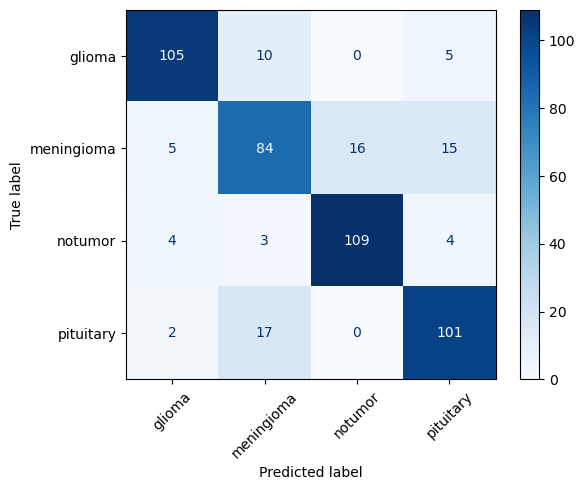

In [33]:
# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.show()